# Study note about behaviors of learning ARD weights

In [4]:
import numpy
import sys
sys.path.append("../")
sys.path.append(".")
from model_criticism_mmd import ModelTrainerTorchBackend, MMD, ModelTrainerTheanoBackend, TwoSampleDataSet
from model_criticism_mmd.backends import kernels_torch

In [5]:
import torch
device_obj = torch.device('cpu')

# Study: Correctness of ARD weightts

## objective

1. We confirm the computed ARD weights are as we expected.
2. We observe how the sigma value works on learninig the ARD weights.

## Settings

We generate the input data with the following way.

The input data has 3 dimensions. Only the 1st dimenstion has huge variance. The 2nd and 3rd features have the same mean and variance.

We cut the input data into 80 samples as `training` and 20 samples as `validation`.

In [8]:
size = 100
n_trial = 5
n_epoch = 500
batch_size = 200

result_stacks_with_sigma = []
result_stacks_without_sigma = []
for i_trial in range(0, n_trial):
    x_1st_dim = numpy.random.normal(loc=1.0, scale=0.0, size=size)
    y_1st_dim = numpy.random.normal(loc=1.0, scale=50.0, size=size)

    x_2_and_3_dim = numpy.random.normal(loc=10.0, scale=0.2, size=(size, 2))
    y_2_and_3_dim = numpy.random.normal(loc=10.0, scale=0.2, size=(size, 2))

    x = numpy.concatenate([numpy.reshape(x_1st_dim, (size, 1)), x_2_and_3_dim], axis=1)
    y = numpy.concatenate([numpy.reshape(y_1st_dim, (size, 1)), y_2_and_3_dim], axis=1)
    
    x_train = x[:80]
    y_train = y[:80]
    x_val = x[80:]
    y_val = y[80:]

    for n_dim in [0, 1, 2]:
        print(f'{n_dim+1} dim. mean(x)={x[:,n_dim].mean()} mean(y)={y[:,n_dim].mean()} var(x)={x[:,n_dim].var()} var(y)={y[:,n_dim].var()}')
    # end for
    
    dataset_train = TwoSampleDataSet(x_train, y_train, device_obj)
    dataset_val = TwoSampleDataSet(x_val, y_val, device_obj)
    
    # with sigma optimization
    trainer_theano = ModelTrainerTheanoBackend()
    trained_obj_theano = trainer_theano.train(x_train, y_train, num_epochs=n_epoch, batchsize=batch_size, opt_sigma=True, x_val=x_val, y_val=y_val, init_sigma_median=True)
    
    mmd_estimator_sigma_opt = MMD(kernels_torch.BasicRBFKernelFunction(opt_sigma=True, device_obj=device_obj), 
                                  device_obj=device_obj)
    trainer_torch = ModelTrainerTorchBackend(mmd_estimator=mmd_estimator_sigma_opt,
                                            device_obj=device_obj)
    trained_obj_torch = trainer_torch.train(dataset_training=dataset_train, 
                                            dataset_validation=dataset_val,
                                            num_epochs=n_epoch, batchsize=batch_size)
    sigma = numpy.exp(trained_obj_torch.kernel_function_obj.get_params()['log_sigma'].cpu().detach().numpy())

    result_stacks_with_sigma.append([
                             (x, y),
                             (trained_obj_theano.scales, trained_obj_torch.scales),
                             (trained_obj_theano.sigma, sigma)])
    # without sigma optimization
    trainer_theano = ModelTrainerTheanoBackend()
    trained_obj_theano = trainer_theano.train(x_train, y_train, num_epochs=n_epoch, batchsize=batch_size, opt_sigma=False, x_val=x_val, y_val=y_val, init_sigma_median=False, init_log_sigma=0.0)
    
    mmd_estimator = MMD(kernels_torch.BasicRBFKernelFunction(opt_sigma=False, device_obj=device_obj), 
                        device_obj=device_obj)
    trainer_torch = ModelTrainerTorchBackend(mmd_estimator=mmd_estimator,
                                            device_obj=device_obj)
    trained_obj_torch = trainer_torch.train(dataset_training=dataset_train, 
                                            dataset_validation=dataset_val,
                                            num_epochs=n_epoch, batchsize=batch_size)
    sigma = numpy.exp(trained_obj_torch.kernel_function_obj.get_params()['log_sigma'].cpu().detach().numpy())
    
    result_stacks_without_sigma.append([
                             (x, y),
                             (trained_obj_theano.scales, trained_obj_torch.scales),
                             (trained_obj_theano.sigma, sigma)])
# end for

Starting with sigma = median; optimizing it


1 dim. mean(x)=1.0 mean(y)=2.5823158088856535 var(x)=0.0 var(y)=2127.5500791987533
2 dim. mean(x)=9.976750276931472 mean(y)=10.04868954044069 var(x)=0.03241438421531112 var(y)=0.04095937253447776
3 dim. mean(x)=9.99661299230106 mean(y)=10.028834114238997 var(x)=0.031876996572428436 var(y)=0.028744321938716504


Compiling...
done
Getting median initial sigma value...
21.8
Input dim 3, representation dim 3
Training on 80 samples (batch 200), validation on 20 (batch 1000)
2 parameters to optimize: scales, log_sigma
     0: avg train MMD^2  0.577750 obj -2.214184,  avg val MMD^2  0.478265  obj -1.398782  elapsed: 0s  sigma: 21.8
     5: avg train MMD^2  0.643725 obj -2.303723,  avg val MMD^2  0.570239  obj -1.497825  elapsed: 0s  sigma: 19.7
    25: avg train MMD^2  0.934388 obj -2.978147,  avg val MMD^2  0.900061  obj -1.996772  elapsed: 0s  sigma: 8.52
    50: avg train MMD^2  0.986921 obj -5.556164,  avg val MMD^2  1.030170  obj -5.028690  elapsed: 0s  sigma: 1.25
   100: avg train MMD^2  1.013744 obj -7.664415,  avg val MMD^2  1.049953  obj -9.259086  elapsed: 0s  sigma: 0.202
   200: avg train MMD^2  0.025000 obj -5.521461,  avg val MMD^2  0.100000  obj -6.907755  elapsed: 0s  sigma: 0.00909
   300: avg train MMD^2  0.025000 obj -5.521461,  avg val MMD^2  0.100000  obj -6.907755  elapsed: 0s

1 dim. mean(x)=1.0 mean(y)=-3.0226779491282416 var(x)=0.0 var(y)=2161.6504745390844
2 dim. mean(x)=10.040574079591138 mean(y)=10.00610402969332 var(x)=0.04493368924200165 var(y)=0.049325862398602434
3 dim. mean(x)=10.031340698264733 mean(y)=9.98857366089206 var(x)=0.0387785627178395 var(y)=0.04374815710120216


done
Getting median initial sigma value...
17.5
Input dim 3, representation dim 3
Training on 80 samples (batch 200), validation on 20 (batch 1000)
2 parameters to optimize: scales, log_sigma
     0: avg train MMD^2  0.482676 obj -2.003281,  avg val MMD^2  0.729707  obj -1.836003  elapsed: 0s  sigma: 17.5
     5: avg train MMD^2  0.512501 obj -2.040037,  avg val MMD^2  0.791491  obj -1.921739  elapsed: 0s  sigma: 16.4
    25: avg train MMD^2  0.788052 obj -2.615049,  avg val MMD^2  1.038379  obj -2.949712  elapsed: 0s  sigma: 7.88
    50: avg train MMD^2  0.955950 obj -3.425593,  avg val MMD^2  1.044234  obj -5.233474  elapsed: 0s  sigma: 2.26
   100: avg train MMD^2  0.967247 obj -4.830257,  avg val MMD^2  1.021323  obj -4.808752  elapsed: 0s  sigma: 0.439
   200: avg train MMD^2  1.012828 obj -8.100004,  avg val MMD^2  1.049970  obj -9.259102  elapsed: 0s  sigma: 0.188
   300: avg train MMD^2  1.012814 obj -8.099053,  avg val MMD^2  1.049999  obj -9.259130  elapsed: 0s  sigma: 0.144


1 dim. mean(x)=1.0 mean(y)=7.7234959539577765 var(x)=0.0 var(y)=2214.942153155882
2 dim. mean(x)=9.99143610735228 mean(y)=9.974125058564738 var(x)=0.03008646600399624 var(y)=0.03658913632491844
3 dim. mean(x)=10.00232052620797 mean(y)=9.99697069395623 var(x)=0.026738543559981117 var(y)=0.04102337878470182


Compiling...
done
Getting median initial sigma value...
15.7
Input dim 3, representation dim 3
Training on 80 samples (batch 200), validation on 20 (batch 1000)
2 parameters to optimize: scales, log_sigma
     0: avg train MMD^2  0.472977 obj -2.031249,  avg val MMD^2  0.891533  obj -1.896442  elapsed: 0s  sigma: 15.7
     5: avg train MMD^2  0.512633 obj -2.094705,  avg val MMD^2  0.951034  obj -1.987840  elapsed: 0s  sigma: 14.4
    25: avg train MMD^2  0.870093 obj -2.766785,  avg val MMD^2  1.037178  obj -2.420777  elapsed: 0s  sigma: 6.22
    50: avg train MMD^2  0.969909 obj -3.573957,  avg val MMD^2  1.043303  obj -4.631855  elapsed: 0s  sigma: 1.87
   100: avg train MMD^2  0.949944 obj -3.705558,  avg val MMD^2  1.000627  obj -4.223264  elapsed: 0s  sigma: 0.979
   200: avg train MMD^2  0.951127 obj -3.729342,  avg val MMD^2  0.998470  obj -4.109234  elapsed: 0s  sigma: 0.792
   300: avg train MMD^2  0.958646 obj -4.055232,  avg val MMD^2  0.999727  obj -4.213667  elapsed: 0s  

1 dim. mean(x)=1.0 mean(y)=-1.8739104242640325 var(x)=0.0 var(y)=2432.697763998849
2 dim. mean(x)=9.986888450121633 mean(y)=10.001659621546917 var(x)=0.040224336588517706 var(y)=0.03661271437959018
3 dim. mean(x)=10.013807541268982 mean(y)=9.997282860682985 var(x)=0.026776177570254994 var(y)=0.03553093512740469


Compiling...
done
Getting median initial sigma value...
21.9
Input dim 3, representation dim 3
Training on 80 samples (batch 200), validation on 20 (batch 1000)
2 parameters to optimize: scales, log_sigma
     0: avg train MMD^2  0.506945 obj -2.067467,  avg val MMD^2  0.563040  obj -1.503978  elapsed: 0s  sigma: 21.9
     5: avg train MMD^2  0.548306 obj -2.115767,  avg val MMD^2  0.614283  obj -1.572672  elapsed: 0s  sigma: 20.3
    25: avg train MMD^2  0.810951 obj -2.543239,  avg val MMD^2  0.887952  obj -2.119143  elapsed: 0s  sigma: 10.5
    50: avg train MMD^2  0.871763 obj -2.759730,  avg val MMD^2  0.963099  obj -2.308663  elapsed: 0s  sigma: 5.37
   100: avg train MMD^2  0.899982 obj -3.034269,  avg val MMD^2  0.949980  obj -2.438731  elapsed: 0s  sigma: 1.84
   200: avg train MMD^2  0.936847 obj -3.716373,  avg val MMD^2  1.020934  obj -5.050677  elapsed: 0s  sigma: 0.29
   300: avg train MMD^2  0.025000 obj -5.521461,  avg val MMD^2  0.100000  obj -6.907755  elapsed: 0s  si

1 dim. mean(x)=1.0 mean(y)=4.154572759252505 var(x)=0.0 var(y)=2389.0175092275636
2 dim. mean(x)=9.988577679948255 mean(y)=9.991574363902814 var(x)=0.04186576692260802 var(y)=0.03846509523600624
3 dim. mean(x)=10.043299143220981 mean(y)=9.975674246670115 var(x)=0.04464271508215127 var(y)=0.04386765301572147


Compiling...
done
Getting median initial sigma value...
20.3
Input dim 3, representation dim 3
Training on 80 samples (batch 200), validation on 20 (batch 1000)
2 parameters to optimize: scales, log_sigma
     0: avg train MMD^2  0.555033 obj -2.139141,  avg val MMD^2  0.597642  obj -1.423708  elapsed: 0s  sigma: 20.3
     5: avg train MMD^2  0.603841 obj -2.203695,  avg val MMD^2  0.642149  obj -1.480498  elapsed: 0s  sigma: 18.6
    25: avg train MMD^2  0.905713 obj -2.963071,  avg val MMD^2  0.808932  obj -1.774895  elapsed: 0s  sigma: 7.81
    50: avg train MMD^2  0.980815 obj -4.009734,  avg val MMD^2  0.925883  obj -2.501597  elapsed: 0s  sigma: 2.06
   100: avg train MMD^2  1.012847 obj -8.372740,  avg val MMD^2  1.049976  obj -9.259107  elapsed: 0s  sigma: 0.175
   200: avg train MMD^2  1.012500 obj -9.222763,  avg val MMD^2  1.050000  obj -9.259131  elapsed: 0s  sigma: 0.0482
   300: avg train MMD^2  1.012500 obj -9.222763,  avg val MMD^2  1.050000  obj -9.259131  elapsed: 0s 

### Observations

(-10.0, 15.0)

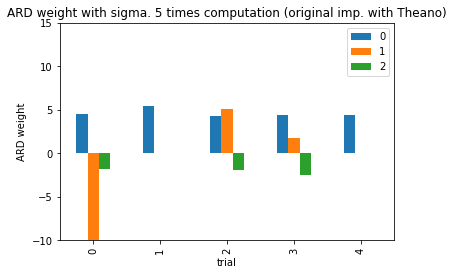

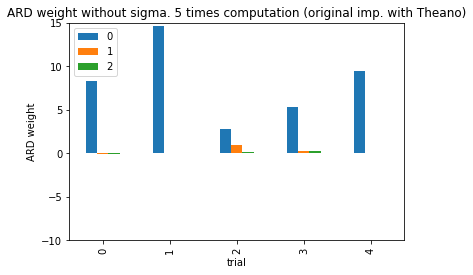

In [9]:
# Theano imp.
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas
import numpy

__df_with_sigma = []
__df_without_sigma = []
for trial_with_sigma, trial_without_sigma in zip(result_stacks_with_sigma, result_stacks_without_sigma):
    __df_with_sigma.append(trial_with_sigma[1][0])
    __df_without_sigma.append(trial_without_sigma[1][0])
# end for
df_with_sigma = pandas.DataFrame(__df_with_sigma, index = list(range(0, n_trial)))
ax = df_with_sigma.plot(kind='bar')
plt.title(f"ARD weight with sigma. {n_trial} times computation (original imp. with Theano)")
plt.ylabel("ARD weight")
plt.xlabel("trial")
ax.set_ylim(-10, 15)
# plot without sigma
df_without_sigma = pandas.DataFrame(__df_without_sigma, index = list(range(0, n_trial)))
ax = df_without_sigma.plot(kind='bar')
plt.title(f"ARD weight without sigma. {n_trial} times computation (original imp. with Theano)")
plt.ylabel("ARD weight")
plt.xlabel("trial")
ax.set_ylim(-10, 15)

(0.0, 15.0)

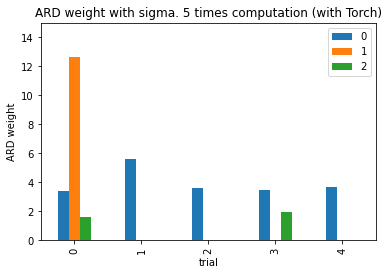

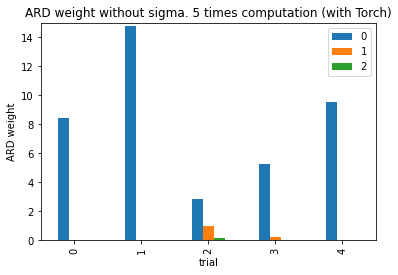

In [10]:
# Theano imp.
__df_with_sigma = []
__df_without_sigma = []
for trial_with_sigma, trial_without_sigma in zip(result_stacks_with_sigma, result_stacks_without_sigma):
    __df_with_sigma.append(trial_with_sigma[1][1])
    __df_without_sigma.append(trial_without_sigma[1][1])
# end for
df_with_sigma = pandas.DataFrame(__df_with_sigma, index = list(range(0, n_trial)))
ax = df_with_sigma.plot(kind='bar')
plt.title(f"ARD weight with sigma. {n_trial} times computation (with Torch)")
plt.ylabel("ARD weight")
plt.xlabel("trial")
ax.set_ylim(0, 15)
# plot without sigma
df_without_sigma = pandas.DataFrame(__df_without_sigma, index = list(range(0, n_trial)))
ax = df_without_sigma.plot(kind='bar')
plt.title(f"ARD weight without sigma. {n_trial} times computation (with Torch)")
plt.ylabel("ARD weight")
plt.xlabel("trial")
ax.set_ylim(0, 15)

### conclusion

The computed ARD weight will not be as we expected __if__ we optimize sigma value at the same time.

Then, we should tune __only scales (ARD weight)__ if we want to obtain the ARD weight.

In [ ]:
%reset

# Study: stability of ARD weights

## Objective

To confirm the computed ARD weighted will be similar.

In the exp, we have the following conditions,

- the training data x and y are fixed.
- the validation data x and y are fixed.
- sigma will not be tuned

In [11]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas
import numpy

from model_criticism_mmd import ModelTrainerTheanoBackend, ModelTrainerTorchBackend, MMD, kernels_torch
import torch
device_obj = torch.device('cpu')

In [12]:
size = 100
x_1st_dim = numpy.random.normal(loc=1.0, scale=0.0, size=size)
y_1st_dim = numpy.random.normal(loc=1.0, scale=50.0, size=size)

x_2_and_3_dim = numpy.random.normal(loc=10.0, scale=0.2, size=(size, 2))
y_2_and_3_dim = numpy.random.normal(loc=10.0, scale=0.2, size=(size, 2))

x = numpy.concatenate([numpy.reshape(x_1st_dim, (size, 1)), x_2_and_3_dim], axis=1)
y = numpy.concatenate([numpy.reshape(y_1st_dim, (size, 1)), y_2_and_3_dim], axis=1)

x_train = x[:80]
y_train = y[:80]
x_val = x[80:]
y_val = y[80:]

for n_dim in [0, 1, 2]:
    print(f'{n_dim+1} dim. mean(x)={x[:,n_dim].mean()} mean(y)={y[:,n_dim].mean()} var(x)={x[:,n_dim].var()} var(y)={y[:,n_dim].var()}')
# end for

1 dim. mean(x)=1.0 mean(y)=-1.9289987121023118 var(x)=0.0 var(y)=2635.82856130085
2 dim. mean(x)=10.003370421375626 mean(y)=9.991030735409678 var(x)=0.03941699910701972 var(y)=0.04441939510345533
3 dim. mean(x)=9.999963300855036 mean(y)=10.014017987619274 var(x)=0.04474273979992369 var(y)=0.03792994077496146


In [13]:
result_stacks = []
n_trial = 5
n_epoch = 500
batch_size = 200
is_opt_sigma = False

dataset_train = TwoSampleDataSet(x_train, y_train, device_obj)
dataset_val = TwoSampleDataSet(x_val, y_val, device_obj)

for i_trial in range(0, n_trial):
    trainer_theano = ModelTrainerTheanoBackend()
    trained_obj_theano = trainer_theano.train(x_train, y_train, num_epochs=n_epoch, batchsize=batch_size, opt_sigma=is_opt_sigma, x_val=x_val, y_val=y_val, init_sigma_median=False, init_log_sigma=0.0)

    mmd_estimator = MMD(kernel_function_obj=kernels_torch.BasicRBFKernelFunction(device_obj=device_obj, opt_sigma=is_opt_sigma),
                       device_obj=device_obj)
    trainer_torch = ModelTrainerTorchBackend(mmd_estimator, device_obj)
    trained_obj_torch = trainer_torch.train(dataset_training=dataset_train, 
                                            dataset_validation=dataset_val,
                                            num_epochs=n_epoch, batchsize=batch_size)

    result_stacks.append([
                             (trained_obj_theano.scales, trained_obj_torch.scales),
                             (trained_obj_theano.sigma, trained_obj_torch.sigma)
    ])
# end for

Using sigma = 1.0
Compiling...
done
Input dim 3, representation dim 3
Training on 80 samples (batch 200), validation on 20 (batch 1000)
1 parameters to optimize: scales
     0: avg train MMD^2  0.851853 obj -3.093609,  avg val MMD^2  0.915869  obj -2.461261  elapsed: 0s
     5: avg train MMD^2  0.854274 obj -3.110175,  avg val MMD^2  0.917177  obj -2.474970  elapsed: 0s
    25: avg train MMD^2  0.880165 obj -3.292620,  avg val MMD^2  0.932249  obj -2.633729  elapsed: 0s
    50: avg train MMD^2  0.909894 obj -3.471857,  avg val MMD^2  0.957332  obj -2.919450  elapsed: 0s
   100: avg train MMD^2  0.945772 obj -3.671567,  avg val MMD^2  0.995963  obj -3.515378  elapsed: 0s
   200: avg train MMD^2  0.978119 obj -3.985929,  avg val MMD^2  1.034084  obj -5.053409  elapsed: 0s
   300: avg train MMD^2  0.992945 obj -4.308070,  avg val MMD^2  1.045082  obj -6.724697  elapsed: 0s
   400: avg train MMD^2  1.001860 obj -4.758177,  avg val MMD^2  1.048067  obj -7.631066  elapsed: 0s
   500: avg tra

We show the ARD weights in 5 times computations. 3 bars represent the ARD weights for each feature.

(0.0, 4.0)

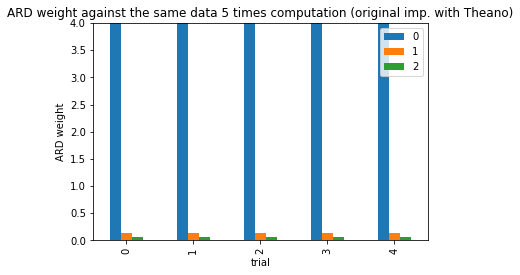

In [14]:
__df_theano_result = []
for i_trial, trial_result in enumerate(result_stacks):
    __df_theano_result.append(trial_result[0][0])
# end for
df_theano_result = pandas.DataFrame(__df_theano_result, index = list(range(0, n_trial)))
ax = df_theano_result.plot(kind='bar')
plt.title(f"ARD weight against the same data {n_trial} times computation (original imp. with Theano)")
plt.ylabel("ARD weight")
plt.xlabel("trial")
ax.set_ylim(0, 4)

(0.0, 4.0)

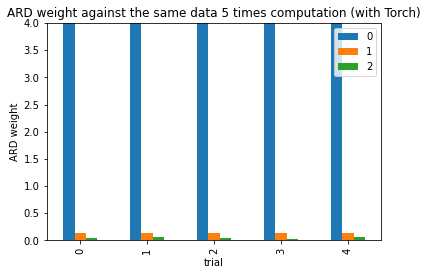

In [15]:
__df_torch_result = []
for i_trial, trial_result in enumerate(result_stacks):
    __df_torch_result.append(trial_result[0][1])
# end for
df_torch_result = pandas.DataFrame(__df_torch_result, index = list(range(0, n_trial)))
ax = df_torch_result.plot(kind='bar')
plt.title(f"ARD weight against the same data {n_trial} times computation (with Torch)")
plt.ylabel("ARD weight")
plt.xlabel("trial")
ax.set_ylim(0, 4)

### concolusion

With the above observation, we confirm that the ARD weight will __converage__ if we fix the input data and the sigma.

In [16]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


# Study: with/without sigma optimizations

In [17]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas
import numpy

from model_criticism_mmd import ModelTrainerTheanoBackend, ModelTrainerTorchBackend, MMD, kernels_torch
import torch
device_obj = torch.device('cpu')

In [18]:
size = 200
x = numpy.random.normal(loc=1.0, scale=0.0, size=(200, 3))
y = numpy.random.normal(loc=1.0, scale=50.0, size=(200, 3))

#x_2_and_3_dim = numpy.random.normal(loc=10.0, scale=0.2, size=(size, 2))
#y_2_and_3_dim = numpy.random.normal(loc=10.0, scale=0.2, size=(size, 2))

#x = numpy.concatenate([numpy.reshape(x_1st_dim, (size, 1)), x_2_and_3_dim], axis=1)
#y = numpy.concatenate([numpy.reshape(y_1st_dim, (size, 1)), y_2_and_3_dim], axis=1)

x_train = x[:100]
y_train = y[:100]
x_val = x[100:150]
y_val = y[100:150]
x_test = x[150:]
y_test = y[150:]

for n_dim in [0, 1, 2]:
    print(f'{n_dim+1} dim. mean(x)={x[:,n_dim].mean()} mean(y)={y[:,n_dim].mean()} var(x)={x[:,n_dim].var()} var(y)={y[:,n_dim].var()}')
# end for
assert len(x_train) == len(y_train) == 100
assert len(x_val) == len(y_val) == 50
assert len(x_test) == len(y_test) == 50

1 dim. mean(x)=1.0 mean(y)=-1.7937470073852102 var(x)=0.0 var(y)=2272.7887177425187
2 dim. mean(x)=1.0 mean(y)=-4.243257303590111 var(x)=0.0 var(y)=2578.3072401074683
3 dim. mean(x)=1.0 mean(y)=-5.004200688806427 var(x)=0.0 var(y)=2411.581815748062


In [19]:
n_epoch = 500
batch_size = 200
is_opt_sigma = False
# with sigma optimizations
trainer_theano = ModelTrainerTheanoBackend()
trained_obj_theano_without_sigma = trainer_theano.train(x_train, y_train, num_epochs=n_epoch, batchsize=batch_size, opt_sigma=is_opt_sigma, x_val=x_val, y_val=y_val, init_sigma_median=False, init_log_sigma=0.0)


dataset_train = TwoSampleDataSet(x_train, y_train, device_obj)
dataset_val = TwoSampleDataSet(x_test, y_test, device_obj)

mmd_estimator = MMD(kernel_function_obj=kernels_torch.BasicRBFKernelFunction(device_obj=device_obj, opt_sigma=is_opt_sigma),
                   device_obj=device_obj)
trainer_torch = ModelTrainerTorchBackend(mmd_estimator, device_obj)
trained_obj_torch = trainer_torch.train(dataset_training=dataset_train, 
                                        dataset_validation=dataset_val,
                                        num_epochs=n_epoch, batchsize=batch_size, x_val=x_val, y_val=y_val)

mmd2_theano, ratio_theano = trainer_theano.mmd_distance(x=x_test, y=y_test, sigma=trained_obj_theano_without_sigma.sigma)
mmd2_torch, ratio_torch = trainer_torch.mmd_distance(x=x_test, y=y_test)
print(f'MMD without the sigma optimization. Theano: {mmd2_theano} Torch: {mmd2_torch}')

Using sigma = 1.0
Compiling...
done
Input dim 3, representation dim 3
Training on 100 samples (batch 200), validation on 50 (batch 1000)
1 parameters to optimize: scales
     0: avg train MMD^2  1.010000 obj -9.220291,  avg val MMD^2  1.020000  obj -9.230143  elapsed: 0s
     5: avg train MMD^2  1.010000 obj -9.220291,  avg val MMD^2  1.020000  obj -9.230143  elapsed: 0s
    25: avg train MMD^2  1.010000 obj -9.220291,  avg val MMD^2  1.020000  obj -9.230143  elapsed: 0s
    50: avg train MMD^2  1.010000 obj -9.220291,  avg val MMD^2  1.020000  obj -9.230143  elapsed: 0s
   100: avg train MMD^2  1.010000 obj -9.220291,  avg val MMD^2  1.020000  obj -9.230143  elapsed: 1s
   200: avg train MMD^2  1.010000 obj -9.220291,  avg val MMD^2  1.020000  obj -9.230143  elapsed: 3s
   300: avg train MMD^2  1.010000 obj -9.220291,  avg val MMD^2  1.020000  obj -9.230143  elapsed: 4s
   400: avg train MMD^2  1.010000 obj -9.220291,  avg val MMD^2  1.020000  obj -9.230143  elapsed: 6s
   500: avg tr

NameError: name 'TwoSampleDataSet' is not defined

In [ ]:
n_epoch = 500
batch_size = 200
is_opt_sigma = True
# with sigma optimizations
trainer_theano = ModelTrainerTheanoBackend()
trained_obj_theano_with_sigma = trainer_theano.train(x_train, y_train, num_epochs=n_epoch, batchsize=batch_size, opt_sigma=is_opt_sigma, x_val=x_val, y_val=y_val, init_sigma_median=True)

dataset_train = TwoSampleDataSet(x_train, y_train, device_obj)
dataset_val = TwoSampleDataSet(x_test, y_test, device_obj)

mmd_estimator = MMD(kernel_function_obj=kernels_torch.BasicRBFKernelFunction(device_obj=device_obj, opt_sigma=is_opt_sigma),
                   device_obj=device_obj)
trainer_torch = ModelTrainerTorchBackend(mmd_estimator, device_obj)
trained_obj_torch = trainer_torch.train(dataset_training=dataset_train, 
                                        dataset_validation=dataset_val,
                                        num_epochs=n_epoch, batchsize=batch_size)

mmd2_theano_with_sigma, ratio_theano = trainer_theano.mmd_distance(x=x_val, y=y_val, sigma=trained_obj_theano_with_sigma.sigma)
mmd2_torch_with_sigma, ratio_torch = trainer_torch.mmd_distance(x=x_val, y=y_val)
print(f'MMD with the sigma optimization. Theano: {mmd2_theano_with_sigma} Torch: {mmd2_torch_with_sigma}')

### Conclusion

Sigma optimization does not seem to give effects to compute MMD^2 distance.